# Project 1

In [7]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from gurobipy import Model, GRB

df_pop = pd.read_csv('population.csv')
df_income = pd.read_csv('avg_individual_income.csv')
df_emp = pd.read_csv('employment_rate.csv')
df_cc = pd.read_csv('child_care_regulated.csv')
df_pot = pd.read_csv('potential_locations.csv')

df_income = df_income.rename(columns={'ZIP code': 'zipcode'})
df_cc = df_cc.rename(columns={'zip_code': 'zipcode'})

for df in [df_pop, df_income, df_emp, df_cc, df_pot]:
    df['zipcode'] = df['zipcode'].astype(str).str[:5]

df = df_pop.merge(df_income, on='zipcode').merge(df_emp, on='zipcode')

df

,zipcode,Total,-5,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+,average income,employment rate
0,10001,27004,744,784,942,1035,2296,3806,3588,2524,...,1704,1225,1323,933,815,616,488,576,102878.033603,0.595097
1,10002,76518,2142,3046,3198,2652,4528,6988,6278,5157,...,4410,6106,4548,4815,4748,2531,2793,2794,59604.041165,0.520662
2,10003,53877,1440,1034,953,7013,6344,7100,6427,3221,...,2698,2350,2274,2793,1854,1646,779,1056,114273.049645,0.497244
3,10004,4579,433,182,161,108,109,601,724,490,...,549,279,199,173,2,15,0,0,132004.310345,0.506661
4,10005,8801,484,204,229,53,989,2604,1144,945,...,652,218,85,92,66,0,0,0,121437.713311,0.665833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,14767,2265,101,219,168,189,119,157,119,120,...,123,173,196,101,75,83,25,25,54623.287671,0.322296
1371,14770,2888,137,197,223,175,190,242,178,80,...,210,177,181,120,191,83,80,41,55523.255814,0.446676
1372,14772,3993,256,253,224,301,163,180,198,256,...,238,272,311,306,170,196,55,58,57164.634146,0.410719
1373,14805,765,31,16,29,24,42,12,31,37,...,29,143,105,36,141,12,8,10,59375.000000,0.679739


In [8]:
set_income = set(df_income['zipcode'].unique())
set_emp = set(df_emp['zipcode'].unique())
set_cc = set(df_cc['zipcode'].unique())
set_pot = set(df_pot['zipcode'].unique())
set_pop = set(df_pop['zipcode'].unique())

print("Unique zipcode：")
print(f"income: {len(set_income)}")
print(f"employment: {len(set_emp)}")
print(f"child care: {len(set_cc)}")
print(f"potential locations: {len(set_pot)}")
print(f"population: {len(set_pop)}")

Unique zipcode：
income: 1534
employment: 1375
child care: 1188
potential locations: 2154
population: 1646


In [9]:
def overlap_ratio(set_a, set_b):
    inter = set_a & set_b
    return len(inter), len(inter)/len(set_a), len(inter)/len(set_b)

sets = {
    'income': set_income,
    'employment': set_emp,
    'child_care': set_cc,
    'potential': set_pot,
    'population': set_pop
}

print("\nzipcode overlap：")
print(f"{'Pair':<30} {'Overlap Count':<15} {'In A (%)':<10} {'In B (%)':<10}")
print("-" * 60)

keys = list(sets.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        a_name, b_name = keys[i], keys[j]
        a_set, b_set = sets[a_name], sets[b_name]
        count, ratio_a, ratio_b = overlap_ratio(a_set, b_set)
        print(f"{a_name:<12} ∩ {b_name:<12} {count:<15} {ratio_a:.2%}{'':<10} {ratio_b:.2%}")


zipcode overlap：
Pair                           Overlap Count   In A (%)   In B (%)  
------------------------------------------------------------
income       ∩ employment   1375            89.63%           100.00%
income       ∩ child_care   1131            73.73%           95.20%
income       ∩ potential    1534            100.00%           71.22%
income       ∩ population   1375            89.63%           83.54%
employment   ∩ child_care   1023            74.40%           86.11%
employment   ∩ potential    1375            100.00%           63.83%
employment   ∩ population   1375            100.00%           83.54%
child_care   ∩ potential    1184            99.66%           54.97%
child_care   ∩ population   1066            89.73%           64.76%
potential    ∩ population   1646            76.42%           100.00%


# Problem 1

In [10]:
import pandas as pd
import numpy as np
import pulp
from math import ceil

child_care = pd.read_csv('child_care_regulated.csv')
population = pd.read_csv('population.csv')
income = pd.read_csv('avg_individual_income.csv')
employment = pd.read_csv('employment_rate.csv')
income = income.rename(columns={'ZIP code': 'zipcode', 'average income':'avg_income'})
employment = employment.rename(columns={'employment rate': 'employment_rate'})
child_care = child_care.rename(columns={'zip_code': 'zipcode'})
for df in [child_care, population, income, employment]:
    df['zipcode'] = df['zipcode'].astype(str).str[:5]

data = population[['zipcode', '-5', '5-9', '10-14']].copy()
data = data.merge(income, on='zipcode', how='left')
data = data.merge(employment, on='zipcode', how='left')

data['avg_income'].fillna(data['avg_income'].median(), inplace=True)
data['employment_rate'].fillna(data['employment_rate'].median(), inplace=True)

data['children_0_5'] = data['-5']
data['children_5_9'] = data['5-9']
data['children_10_12'] = (3/5) * data['10-14'] 
data['children_5_12'] = data['children_5_9'] + data['children_10_12']
data['children_0_12'] = data['children_0_5'] + data['children_5_12']

data['high_demand'] = ((data['avg_income'] <= 60000) | (data['employment_rate'] >= 0.6)).astype(int)

data['required_total_slots'] = data.apply(
    lambda row: ceil(0.5 * row['children_0_12']) if row['high_demand'] else ceil(row['children_0_12'] / 3),
    axis=1
)
data['required_0_5_slots'] = np.ceil((2/3) * data['children_0_5']).astype(int)

child_care['total_capacity'] = child_care['total_capacity'].fillna(0)
child_care['infant_capacity'] = child_care['infant_capacity'].fillna(0)
child_care['toddler_capacity'] = child_care['toddler_capacity'].fillna(0)
child_care['preschool_capacity'] = child_care['preschool_capacity'].fillna(0)
child_care['0_5_capacity'] = (child_care['infant_capacity'] + 
                              child_care['toddler_capacity'] + 
                              child_care['preschool_capacity'])

existing_summary = child_care.groupby('zipcode').agg(
    existing_total_slots=('total_capacity', 'sum'),
    existing_0_5_slots=('0_5_capacity', 'sum')
).reset_index()

data = data.merge(existing_summary, on='zipcode', how='left')
data[['existing_total_slots', 'existing_0_5_slots']] = data[['existing_total_slots', 'existing_0_5_slots']].fillna(0)

/var/folders/mx/q9d_jk3s0931b7y4rxjnmgf00000gn/T/ipykernel_76933/2055851849.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['avg_income'].fillna(data['avg_income'].median(), inplace=True)
/var/folders/mx/q9d_jk3s0931b7y4rxjnmgf00000gn/T/ipykernel_76933/2055851849.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [11]:
data.isnull().any()

zipcode                 False
-5                      False
5-9                     False
10-14                   False
avg_income              False
employment_rate         False
children_0_5            False
children_5_9            False
children_10_12          False
children_5_12           False
children_0_12           False
high_demand             False
required_total_slots    False
required_0_5_slots      False
existing_total_slots    False
existing_0_5_slots      False
dtype: bool

In [12]:
len(population['zipcode'].unique())

1646

In [14]:
zip_data = data.set_index('zipcode').T.to_dict()
facilities = []
for _, row in child_care.iterrows():
    if row['total_capacity'] > 0:  
        nf = row['total_capacity']
        n5 = row['0_5_capacity']
        max_expansion = min(1.2 * nf, 500)
        max_expansion = int(max_expansion) 
        unit_cost = (20000 / nf) + 200 if nf > 0 else 1000
        facilities.append({
            'facility_id': row['facility_id'],
            'zipcode': row['zipcode'],
            'nf': nf,
            'n5': n5,
            'max_exp': max_expansion,
            'unit_cost': unit_cost,
            'extra_cost': 20000 + 200 * nf
        })

In [15]:
prob = pulp.LpProblem("Eliminate_Child_Care_Deserts", pulp.LpMinimize)

# DV
# x[z, s]
x_vars = {}
for z in zip_data:
    for s in ['S', 'M', 'L']:
        x_vars[(z, s)] = pulp.LpVariable(f"x_{z}_{s}", lowBound=0, cat='Integer')

# e[f], e5[f], y[f]
e_vars = {}
e5_vars = {}
y_vars = {}
for f in facilities:
    fid = f['facility_id']
    e_vars[fid] = pulp.LpVariable(f"e_{fid}", lowBound=0, upBound=f['max_exp'], cat='Integer')
    e5_vars[fid] = pulp.LpVariable(f"e5_{fid}", lowBound=0, upBound=f['max_exp'], cat='Integer')
    y_vars[fid] = pulp.LpVariable(f"y_{fid}", cat='Binary')

total_cost = 0

# build 
for (z, s), var in x_vars.items():
    cost = {'S': 65000+50*100, 'M': 95000+100*100, 'L': 115000+200*100}[s]
    total_cost += cost * var

# expand
for f in facilities:
    fid = f['facility_id']
    e = e_vars[fid]
    y = y_vars[fid]
    e5 = e5_vars[fid]
    total_cost += f['unit_cost'] * e + f['extra_cost'] * y + 100 * e5

prob += total_cost

# Constraints
# (1) required_total_slots
for z in zip_data:
    required = zip_data[z]['required_total_slots']
    existing = zip_data[z]['existing_total_slots']
    new_slots = sum({'S':100, 'M':200, 'L':400}[s] * x_vars[(z,s)] for s in ['S','M','L'])
    expansion_slots = pulp.lpSum(e_vars[f['facility_id']] for f in facilities if f['zipcode']==z)
    prob += existing + new_slots + expansion_slots >= required, f"TotalSlots_{z}"

# (2) required_0_5_slots
for z in zip_data:
    required = zip_data[z]['required_0_5_slots']
    existing = zip_data[z]['existing_0_5_slots']
    new_05_slots = sum({'S':50, 'M':100, 'L':200}[s] * x_vars[(z,s)] for s in ['S','M','L'])
    expansion_05_slots = pulp.lpSum(e5_vars[f['facility_id']] for f in facilities if f['zipcode']==z)
    prob += existing + new_05_slots + expansion_05_slots >= required, f"05Slots_{z}"

# (3) e5 <= e for each facility
for f in facilities:
    fid = f['facility_id']
    prob += e5_vars[fid] <= e_vars[fid], f"e5_le_e_{fid}"

# (4) e >= nf, y = 1 (Big M)
M_val = 500
for f in facilities:
    fid = f['facility_id']
    nf = f['nf']
    e = e_vars[fid]
    y = y_vars[fid]
    prob += e <= (nf - 1) + M_val * y, f"Linearize_{fid}"


print("Start Solving...")
prob.solve()

print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Minimal Cost: ${pulp.value(prob.objective):,.2f}")

Start Solving...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yihanyu/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/mx/q9d_jk3s0931b7y4rxjnmgf00000gn/T/997aac5319e14bbcaaa72cc214f078bd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/mx/q9d_jk3s0931b7y4rxjnmgf00000gn/T/997aac5319e14bbcaaa72cc214f078bd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 34503 COLUMNS
At line 291665 RHS
At line 326164 BOUNDS
At line 377912 ENDATA
Problem MODEL has 34498 rows, 51747 columns and 101920 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.17386e+08 - 0.51 seconds
Cgl0003I 0 fixed, 4278 tightened bounds, 1831 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1473 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1018

In [19]:
print("\n--- New Facility ---")
for s, name in [('S','Small'), ('M','Median'), ('L','Large')]:
    total_new = sum(x_vars[(z,s)].varValue for z in zip_data if (z,s) in x_vars)
    if total_new > 0:
        print(f"{name}: {int(total_new)} 个")

print("\n--- Expansion ---")
exp_count = 0
for f in facilities:
    fid = f['facility_id']
    e_val = e_vars[fid].varValue
    e5_val = e5_vars[fid].varValue
    if e_val > 0:
        exp_count += 1
        print(f"{fid}: expand {int(e_val)} slot (0-5: {int(e5_val)})")
        if exp_count >= 10:
            print("... More")
            break


--- New Facility ---
Small: 477 个
Median: 173 个
Large: 1355 个

--- Expansion ---
40163: expand 119 slot (0-5: 113)
42005: expand 67 slot (0-5: 48)
73544: expand 59 slot (0-5: 59)
173555: expand 84 slot (0-5: 84)
250057: expand 239 slot (0-5: 239)
262387: expand 111 slot (0-5: 52)
624233: expand 244 slot (0-5: 244)
666034: expand 92 slot (0-5: 92)
675105: expand 17 slot (0-5: 17)
677764: expand 179 slot (0-5: 179)
... More


In [37]:
import pandas as pd

results = []

for z in zip_data:
    new_S = x_vars.get((z, 'S'), None)
    new_M = x_vars.get((z, 'M'), None)
    new_L = x_vars.get((z, 'L'), None)
    
    new_S_val = int(new_S.varValue) if new_S else 0
    new_M_val = int(new_M.varValue) if new_M else 0
    new_L_val = int(new_L.varValue) if new_L else 0
    
    exp_total = sum(e_vars[f['facility_id']].varValue for f in facilities if f['zipcode'] == z)
    exp_05 = sum(e5_vars[f['facility_id']].varValue for f in facilities if f['zipcode'] == z)
    
    results.append({
        'zipcode': z,
        'new_small': new_S_val,
        'new_medium': new_M_val,
        'new_large': new_L_val,
        'expansion_total': int(exp_total),
        'expansion_0_5': int(exp_05),
        'existing_total': zip_data[z]['existing_total_slots'],
        'existing_0_5': zip_data[z]['existing_0_5_slots'],
        'required_total': zip_data[z]['required_total_slots'],
        'required_0_5': zip_data[z]['required_0_5_slots']
    })

df_result = pd.DataFrame(results)
df_result 

,zipcode,new_small,new_medium,new_large,expansion_total,expansion_0_5,existing_total,existing_0_5,required_total,required_0_5
0,6390,1,0,0,0,0,0.0,0.0,2.0,0.0
1,10001,0,0,0,496,496,609.0,0.0,698.0,496.0
2,10002,0,0,0,1410,1410,4729.0,18.0,3554.0,1428.0
3,10003,0,0,0,960,960,1995.0,0.0,1016.0,960.0
4,10004,1,0,0,239,239,263.0,0.0,238.0,289.0
...,...,...,...,...,...,...,...,...,...,...
1641,14774,0,0,0,3,3,62.0,0.0,23.0,3.0
1642,14785,0,0,0,0,0,0.0,0.0,0.0,0.0
1643,14788,1,0,0,0,0,0.0,0.0,1.0,0.0
1644,14805,1,0,0,0,0,8.0,0.0,33.0,21.0


In [36]:
output_path = "facility_expansion_and_new_build_summary.xlsx"
df_result.to_excel(output_path, index=False)


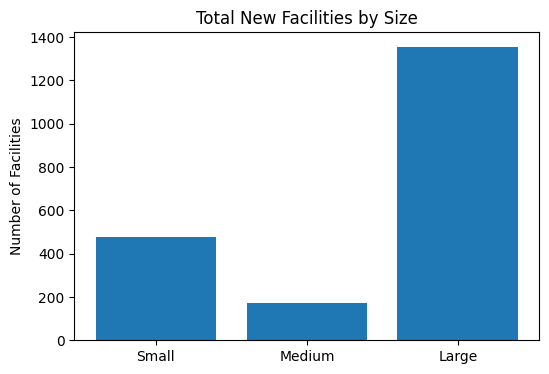

In [34]:
import matplotlib.pyplot as plt

total_new = {
    'Small': df_result['new_small'].sum(),
    'Medium': df_result['new_medium'].sum(),
    'Large': df_result['new_large'].sum()
}

plt.figure(figsize=(6,4))
plt.bar(total_new.keys(), total_new.values())
plt.title("Total New Facilities by Size")
plt.ylabel("Number of Facilities")
plt.show()


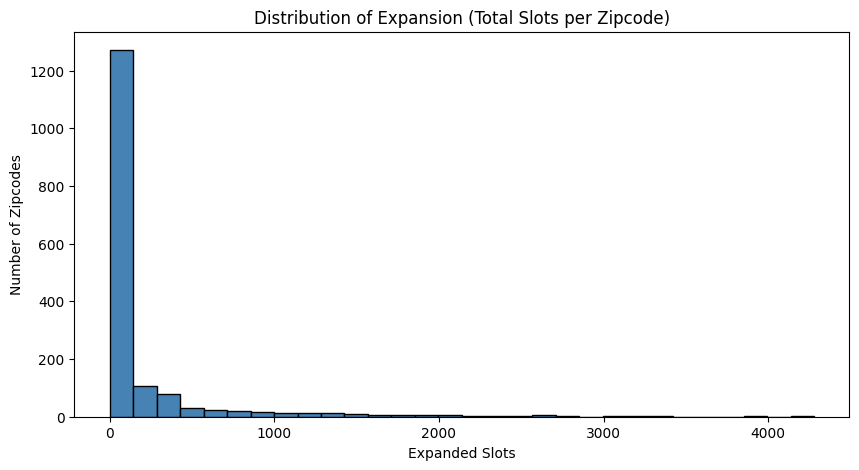

In [25]:
df_result['total_new_facilities'] = df_result[['new_small', 'new_medium', 'new_large']].sum(axis=1)

plt.figure(figsize=(10,5))
plt.hist(df_result['expansion_total'], bins=30, color='steelblue', edgecolor='black')
plt.title("Distribution of Expansion (Total Slots per Zipcode)")
plt.xlabel("Expanded Slots")
plt.ylabel("Number of Zipcodes")
plt.show()


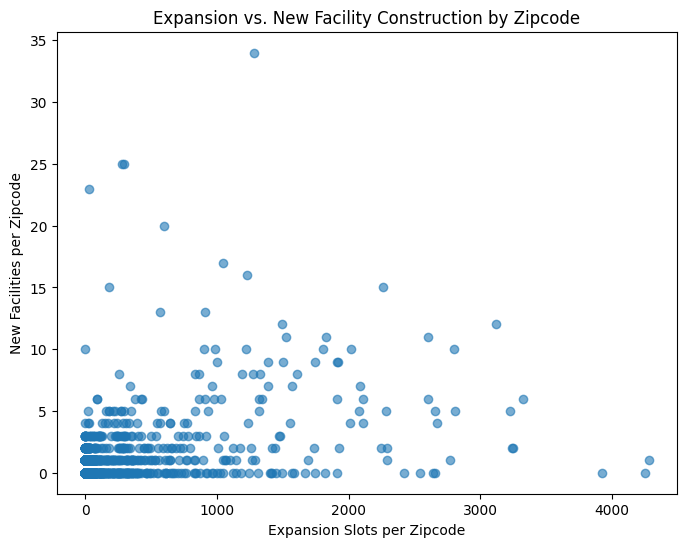

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(df_result['expansion_total'], df_result['total_new_facilities'], alpha=0.6)
plt.xlabel("Expansion Slots per Zipcode")
plt.ylabel("New Facilities per Zipcode")
plt.title("Expansion vs. New Facility Construction by Zipcode")
plt.show()



--- Expansion Statistics ---
Average expansion_total: 184.48
Variance expansion_total: 223967.40
Average expansion_0_5: 177.54
Variance expansion_0_5: 224288.16
Average 0–5 ratio: 87.30%
Variance 0–5 ratio: 0.0868


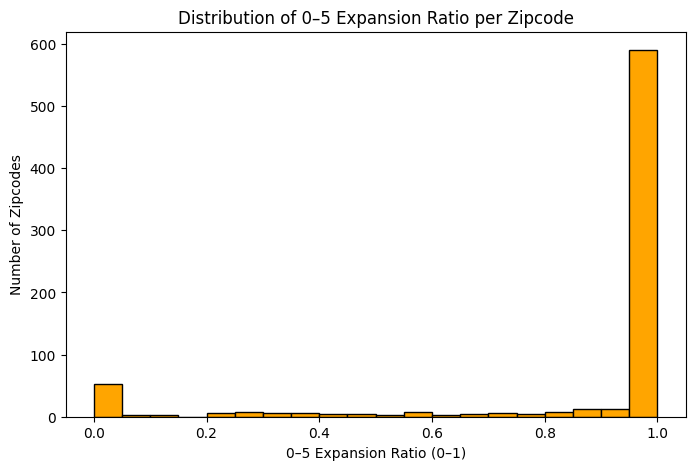

In [32]:
import numpy as np

df_result['expansion_0_5_ratio'] = np.where(
    df_result['expansion_total'] > 0,
    df_result['expansion_0_5'] / df_result['expansion_total'],
    np.nan  
)

mean_total = df_result['expansion_total'].mean()
var_total = df_result['expansion_total'].var()

mean_05 = df_result['expansion_0_5'].mean()
var_05 = df_result['expansion_0_5'].var()

mean_ratio = df_result['expansion_0_5_ratio'].mean(skipna=True)
var_ratio = df_result['expansion_0_5_ratio'].var(skipna=True)

print("\n--- Expansion Statistics ---")
print(f"Average expansion_total: {mean_total:.2f}")
print(f"Variance expansion_total: {var_total:.2f}")
print(f"Average expansion_0_5: {mean_05:.2f}")
print(f"Variance expansion_0_5: {var_05:.2f}")
print(f"Average 0–5 ratio: {mean_ratio:.2%}")
print(f"Variance 0–5 ratio: {var_ratio:.4f}")

plt.figure(figsize=(8,5))
plt.hist(df_result['expansion_0_5_ratio'].dropna(), bins=20, color='orange', edgecolor='black')
plt.title("Distribution of 0–5 Expansion Ratio per Zipcode")
plt.xlabel("0–5 Expansion Ratio (0–1)")
plt.ylabel("Number of Zipcodes")
plt.show()


In [33]:
total_expansion_sum = df_result['expansion_total'].sum()
total_expansion_05_sum = df_result['expansion_0_5'].sum()

print("\n--- Total Expansion Summary ---")
print(f"Total expansion slots (all zipcodes): {int(total_expansion_sum):,}")
print(f"Total 0–5 expansion slots (all zipcodes): {int(total_expansion_05_sum):,}")
print(f"Share of 0–5 in total expansion: {total_expansion_05_sum / total_expansion_sum:.2%}")



--- Total Expansion Summary ---
Total expansion slots (all zipcodes): 303,660
Total 0–5 expansion slots (all zipcodes): 292,227
Share of 0–5 in total expansion: 96.23%
